# Analysis & Visualisation

Firstly we will load in the csv output from before skew transformations, run some brief checks to ensure the data loaded correctly, before looking at the data in more detail. For clarity this analysis will refer to the currency in pounds sterling, although no currency label is given for the data.

         id  member_id  loan_amount  funded_amount_inv  term  int_rate  \
0  38676116   41461848       8000.0             8000.0    36    0.0749   
1  38656203   41440010      13200.0            13200.0    36    0.0699   
2  38656154   41439961      16000.0            16000.0    36    0.0749   
3  38656128   41439934      15000.0            15000.0    36    0.1431   
4  38656121   41439927      15000.0            15000.0    36    0.0603   

   instalment grade sub_grade employment_length  ... total_rec_int  \
0      248.82     A        A4           5 years  ...        512.21   
1      407.52     A        A3           9 years  ...        787.94   
2      497.63     A        A4           8 years  ...        824.54   
3      514.93     C        C4            1 year  ...        947.47   
4      456.54     A        A1         10+ years  ...        770.93   

   total_rec_late_fee recoveries collection_recovery_fee last_payment_date  \
0                 0.0        0.0                     0.0

<Axes: >

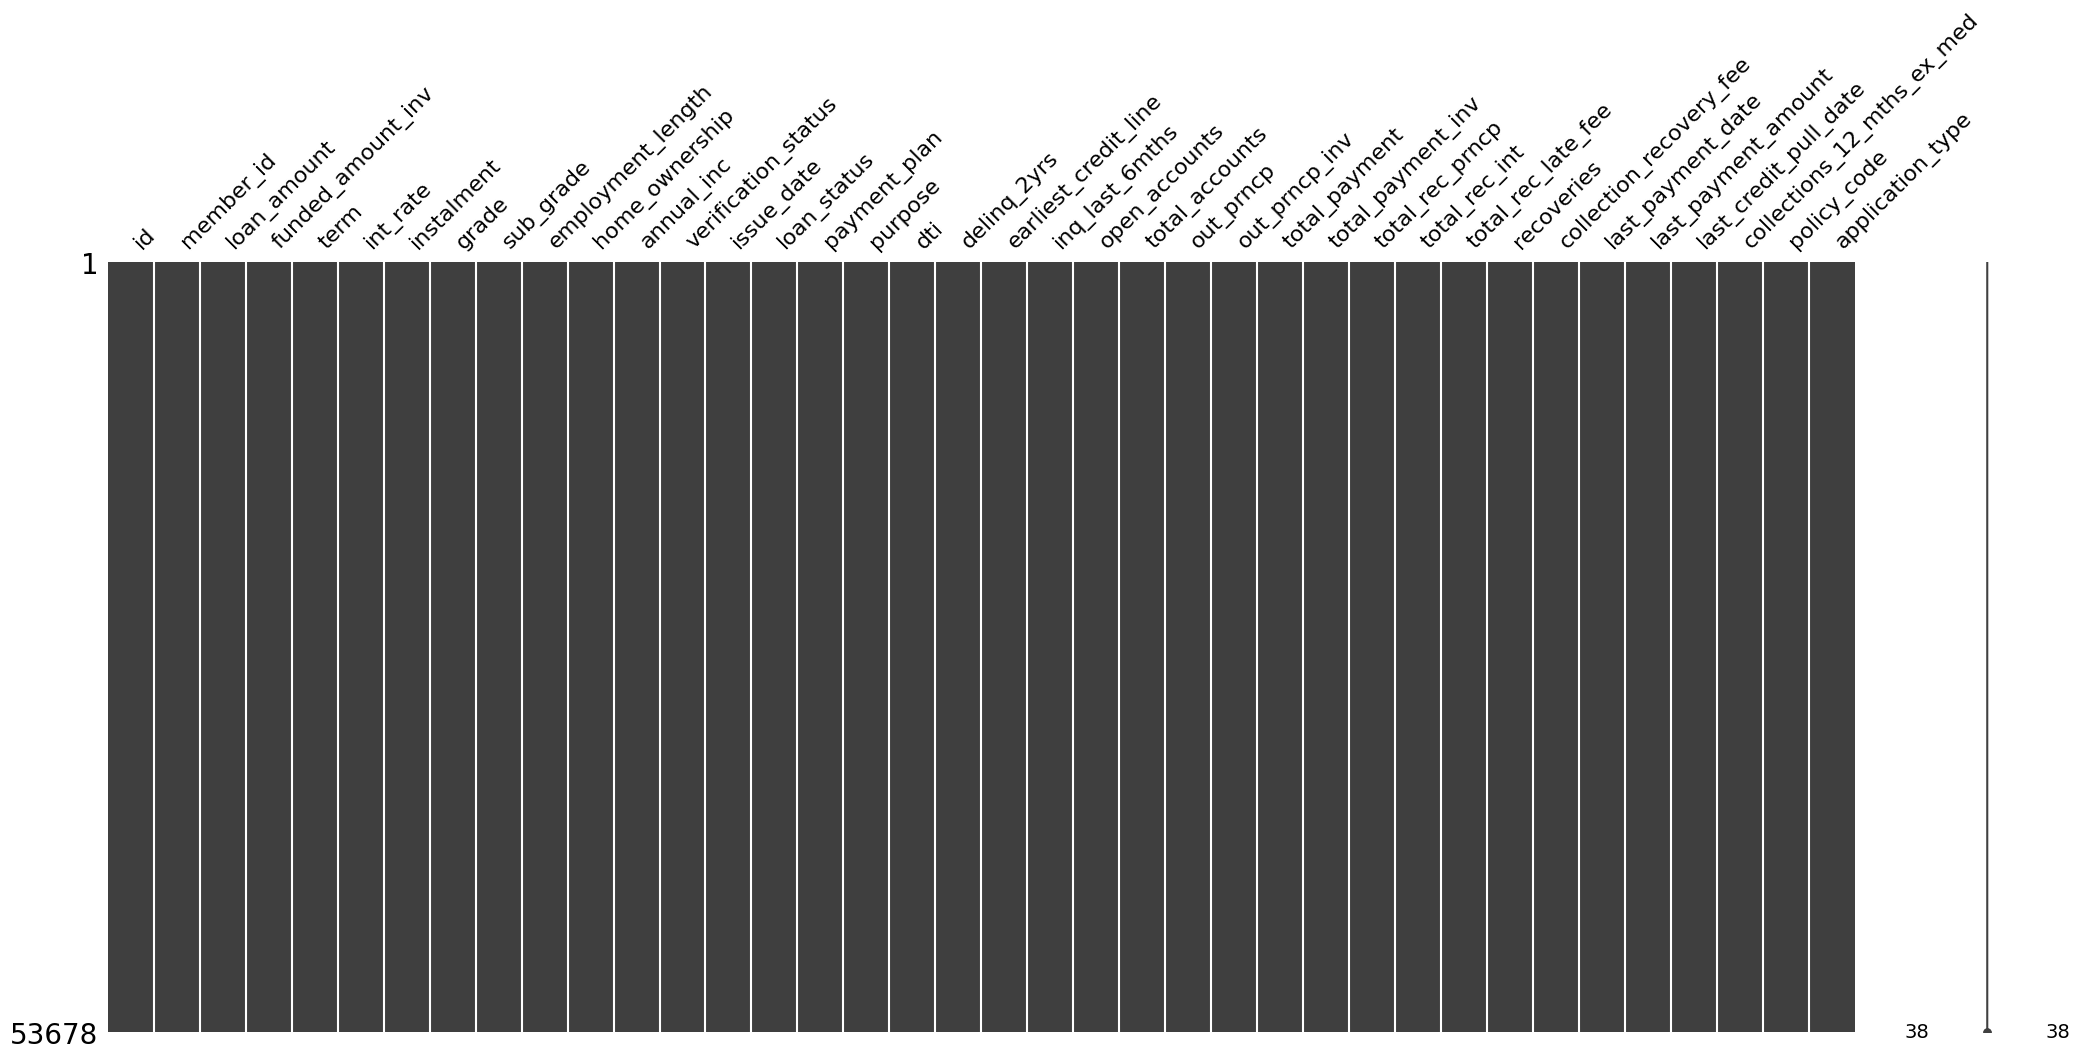

In [1]:
import pandas as pd

analysis_df = pd.read_csv("mod_loan_payments_pre_skew.csv")   #imports extracted csv file before skew transformations

print(analysis_df.head())                                             # prints df to check load

import missingno as msno

msno.matrix(analysis_df)                                      #prints visualisation to check removal of nulls

# Current State of the Loans

In this section, we will summarise what percentage of the loans are paid back compared to the total payment expected with interest and visualise the results.

The total to be paid back on a loan is original loan amount + interest. This can be calculated from the monthly instalment amount mulitpled by the term length in months. A new column will be created in the dataframe to do this called full_repayment_amount.

We can also make projections on how much of the loan portfolio will be repaid over time, and new columns will be created to show this projection over the next 6 months.

The percentage of loans currently paid off is 69.54 %


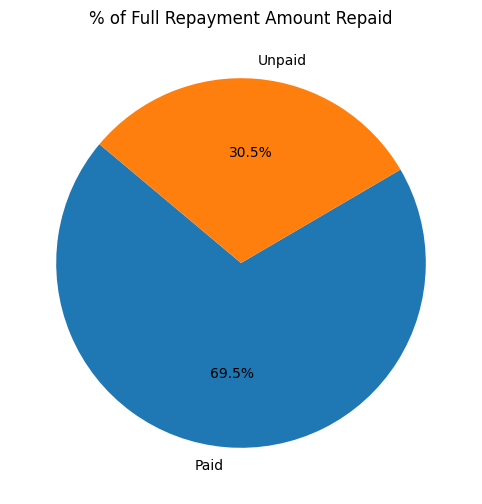

In [2]:
analysis_df['full_repayment_amount'] = analysis_df['instalment'] * analysis_df['term']      #new column in dataframe to calculate total amount payable

#print(analysis_df.head())      #check new column in dataframe

current_percentage_paid = 100 * (analysis_df['total_payment'].sum() / analysis_df['full_repayment_amount'].sum())

#print(current_percentage_paid)
print(f"The percentage of loans currently paid off is {current_percentage_paid.round(2)} %")

#Plot as a Pie Chart
import matplotlib.pyplot as plt

labels = ['Paid', 'Unpaid']
sizes = [current_percentage_paid, 100-current_percentage_paid]         # % Distribution

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

plt.title('% of Full Repayment Amount Repaid')  # Title

# Display the plot
plt.show()


At the generation of this dataset 69.5% of the total loan amount had been repaid. To predict this in the future we should not just apply another 6 months on top of what is already there as some loans will have been paid back in full and shouldn't be counted, and others will have less than 6 months to go so only the exact amount remaining should be counted. The first step is to calculate this as a new column for 1 month.

In [3]:
def compute_new_col(row):
    """Function to calculate the predicted total paid in 1 month"""
    if (row['full_repayment_amount']) - (row['total_payment'] + row['instalment'])  > 0:
        return row['total_payment'] + row['instalment']
    else:
        return row['total_payment']
    
analysis_df['1_month'] = analysis_df.apply(compute_new_col, axis=1)

print(f"The total amount paid after 1 additional month is £{(analysis_df['1_month'].sum().round(2))}")
percentage_paid_1_month = (analysis_df['1_month'].sum() / analysis_df['full_repayment_amount'].sum()*100)
print(f"The percentage of loans paid after 1 month is {percentage_paid_1_month.round(2)} %")

The total amount paid after 1 additional month is £666469270.58
The percentage of loans paid after 1 month is 71.42 %


After manually calculating some random rows, we can see that this approach works correctly and so can now be extended to create a small dataframe with the cumulative total payments per month, the total to be paid (fixed) and the percentage of loans paid off entirely.

   months    total_paid  full_repayment_amount_due  percentage_paid
0       0  6.489962e+08               9.332292e+08            69.54
1       1  6.664693e+08               9.332292e+08            71.42
2       2  6.806420e+08               9.332292e+08            72.93
3       3  6.929298e+08               9.332292e+08            74.25
4       4  7.043234e+08               9.332292e+08            75.47
5       5  7.154099e+08               9.332292e+08            76.66
6       6  7.262172e+08               9.332292e+08            77.82


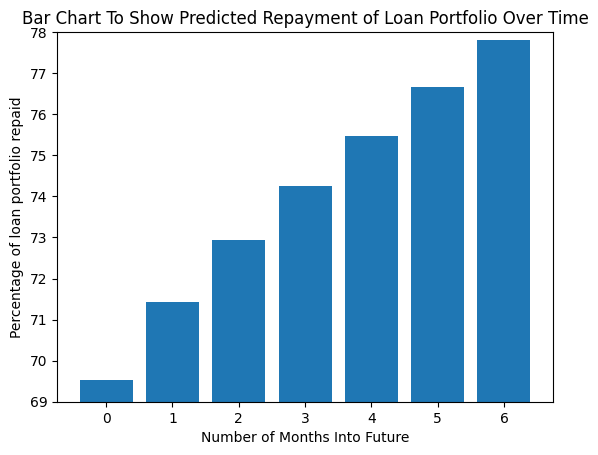

In [4]:
from db_utils_local import DataFrameTransform

dftransformer = DataFrameTransform(analysis_df)

#dftransformer.delete_column('1_month')     # Delete the 1_month column created in last step

def compute_payment_for_months(row, months):
    """Function that calculates the payment for a given number of months"""
    if (row['full_repayment_amount'] - (row['total_payment'] + (months * row['instalment']))) > 0:
        return row['total_payment'] + months * row['instalment']
    else:
        return row['total_payment']

 
def create_summary_dataframe(df, max_months=6):
    """Function that creates a new DataFrame with total sums for 0 to 6 months"""
    results = []
    full_repayment_amount_due = df['full_repayment_amount'].sum()
    for month in range(max_months + 1):
        total_paid = df.apply(compute_payment_for_months, axis=1, months=month).sum()
        results.append({'months': month, 'total_paid': total_paid, 'full_repayment_amount_due': full_repayment_amount_due, 'percentage_paid': ((100 * total_paid / full_repayment_amount_due).round(2))})
    return pd.DataFrame(results)


summary_df = create_summary_dataframe(analysis_df)      # Create a summary DataFrame

print(summary_df)

import matplotlib.pyplot as plt
import numpy as np

x = summary_df['months']
y = summary_df['percentage_paid']

plt.bar(x,y)

plt.title("Bar Chart To Show Predicted Repayment of Loan Portfolio Over Time")
plt.xlabel("Number of Months Into Future")
plt.ylabel("Percentage of loan portfolio repaid")
plt.ylim(bottom=69, top=78)
plt.show()


The table above shows that if all debtors make their scheduled repayments for the next 6 months, then the loan portfolio will be 77.82% repaid at the end of the six month period, compared to 69.54% repaid at the present time. This is also visualised more simply in the bar chart above.

## Calculating Loss

The company wants to check what percentage of loans have been a loss to the company. Loans marked as Charged Off in the loan_status column represent a loss to the company.

In this section we will calculate the percentage of charged off loans historically and the total amount that was paid towards these loans before being charged off, as well as the value of the loss due to these loans being charged off.

To calculate the percentage of charged off loans historically, we must do the following steps:

- Filter by category in loan_status column (including both the charged off categories that exist within the dataframe)
- Count the number of rows within these categories, to get the number of historically charged off loans.
- Percentage charged off = category row count / row count



In [5]:
charged_off_df = analysis_df[(analysis_df['loan_status'] == 'Charged Off') | (analysis_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off')]

print(f"There are {(analysis_df.shape[0])} loans in the portfolio.")
print(f"There are {(charged_off_df.shape[0])} loans that have been charged off historically.")
percentage_loans_charged_off = (((charged_off_df.shape[0])/(analysis_df.shape[0]))*100)
print(f"Therefore {round(percentage_loans_charged_off,2)}% of the loan portfolio has been charged off historically.")

There are 53678 loans in the portfolio.
There are 5809 loans that have been charged off historically.
Therefore 10.82% of the loan portfolio has been charged off historically.


Now we will calculate the total amount that was paid towards these loans before being charged off, which requires the following steps:

- Filter by category in loan_status column (including both the charged off categories that exist within the dataframe)
- New total_loss column = loan_amount - full_repayment_amount (do this per row within these categories)
- Percentage loss = the sum of total_loss / the sum of full_repayment_amount


In [6]:
print(f"The charged off loans were for a total amount of £{charged_off_df['loan_amount'].sum().round(2)}.")
print(f"The charged off loans were worth a total amount of £{charged_off_df['full_repayment_amount'].sum().round(2)} if paid in full.")
print(f"The total amount repaid on these loans was £{charged_off_df['total_payment'].sum().round(2)}.")
charged_off_loss = (charged_off_df['full_repayment_amount'].sum()) - (charged_off_df['total_payment'].sum())
print(f"This represents a loss of £{charged_off_loss.round(2)}.")

print(f"The total value of the portfolio is £{analysis_df['full_repayment_amount'].sum().round(2)}.")

percentage_loss = ((charged_off_loss / analysis_df['full_repayment_amount'].sum()) * 100)

print(f"This loss of represents {percentage_loss.round(2)}% of the overall value of the loan portfolio.")

The charged off loans were for a total amount of £78588950.0.
The charged off loans were worth a total amount of £107225912.82 if paid in full.
The total amount repaid on these loans was £38781642.17.
This represents a loss of £68444270.65.
The total value of the portfolio is £933229222.97.
This loss of represents 7.33% of the overall value of the loan portfolio.


This analysis above shows that although 10.82% of loans have been charged off, this actually represents 7.33% of the overall value of the loan portfolio. The value of this loss is £68.4 million pounds.

## Calculating Projected Loss

In the previous section it was calculated that there will be a total loss of £68.4 million, which would have been recieved if the charged off loans had been paid off in full. In this section we will look at this loss projected over the remaining term of the charged off loans, as the loss is gradually crystallised over time.

This is done using the following steps:
- Using a function to check if a loan is already paid off or not in any given month.
- Using a separate function to create a new dataframe with a projection of how much would have been paid off by these charged off loans each month, for any duration (although I used 60 months)
- Using the first function within the second function to ensure only loans that would still expect payment are added to the dataframe produced by the second function.
- Creating a cumulative loss column to add the monthly losses into a cumulative amount, so that increasing loss can be shown clearly over time.

These numbers were converted into millions, for ease of viewing. 
The last step is a particularly useful tool for visualisng the cumulative losses as they crystallise over time.

In [7]:
def compute_loss_for_months(row, months):
    """Function that calculates the loss for a given number of months"""
    if (row['full_repayment_amount'] - (row['total_payment'] + (months * row['instalment']))) > 0:
        return row['instalment']
    else:
        return 0

 
def create_loss_dataframe(df, max_months=60):
    """Function that creates a new DataFrame with total sums for 0 to 60 months"""
    results = []
    for month in range(max_months + 1):
        total_loss = df.apply(compute_loss_for_months, axis=1, months=month).sum()
        results.append({'months': month, 'total_loss': (total_loss / 1000000)})  # Convert values into millions to remove exponential values in new dataframe.
    return pd.DataFrame(results)


loss_df = create_loss_dataframe(charged_off_df)      # Create a summary DataFrame
loss_df['cumulative_loss'] = (loss_df['total_loss']).cumsum()

print(loss_df)


    months  total_loss  cumulative_loss
0        0    2.314855         2.314855
1        1    2.307280         4.622135
2        2    2.299523         6.921658
3        3    2.290865         9.212523
4        4    2.280040        11.492563
..     ...         ...              ...
56      56    0.047098        69.702929
57      57    0.025932        69.728861
58      58    0.015350        69.744211
59      59    0.006942        69.751153
60      60    0.002889        69.754043

[61 rows x 3 columns]


It can be seen here that the cumulative loss is £ 69.8 Million after 60 months. There is some variance here in the final projected loss compared to our earlier projected loss of £ 68.4 Million.

Wherever the term 'full_repayment_amount' is used in the code, this represents the installment amount multiplied by the term of the loan. Some loans appear to have had their installment amount changed, thereby increasing the term of the loan, but with only the installment amount being altered on the dataframe. These loans can be identified where installment multiplied by loan term does not equal the amount due to be repaid.

This can be seen quickly within the dataframe; for example within the 5810 charged off loans if you select only the 369 loans for £10,000 and multiply the term by the installment amount, for 8 of these loans, the result is a total repayment of less than the loan amount. There are more loans that result in an amount that is likley insufficient to cover the interest expected for the loan. 

Whilst this is a small proportion of the loans, it could easily account for the extra £ 1.4 Million in losses as the installments will continue to be be counted beyond the expected number of payments until the full amount of the loan and interest is repaid. This also explains why the cumulative loss continues to slowly increase over time, despite the majority of loans being for 36 months.

This projected loss is visualised below.

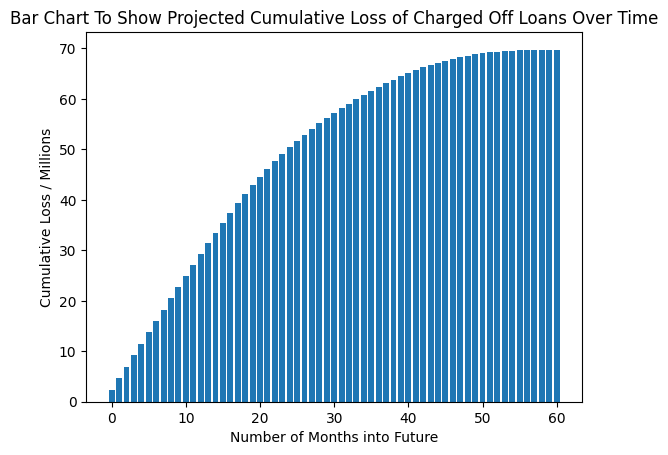

In [8]:
import matplotlib.pyplot as plt
import numpy as np

x = loss_df['months']
y = loss_df['cumulative_loss']

plt.bar(x,y)

plt.title("Bar Chart To Show Projected Cumulative Loss of Charged Off Loans Over Time")
plt.xlabel("Number of Months into Future")
plt.ylabel("Cumulative Loss / Millions")
plt.show()

## Possible Loss

There is a subset of customers who are currently behind with their loan payments and represent a risk to company revenue. In this section we will evaluate the following:

- What percentage do users in this bracket currently represent as a percentage of all loans? 
- Calculate the total amount of customers in this bracket and how much loss the company would incur their status was changed to Charged Off. 
- What is the projected loss of these loans if the customer were to finish the full loans term?

First we need to generate a list of the categories in 'loan_status' to see which can be used to filter for late loan payments

In [9]:
print(analysis_df['loan_status'].value_counts())

loan_status
Fully Paid                                             26795
Current                                                19105
Charged Off                                             5453
Does not meet the credit policy. Status:Fully Paid       976
Late (31-120 days)                                       572
Does not meet the credit policy. Status:Charged Off      356
In Grace Period                                          264
Late (16-30 days)                                        105
Default                                                   52
Name: count, dtype: int64


Loan status codes 'Late (31-120 days)' and 'Late (16-30 days)' show the loans that are currently late. It appears that 264 loans are also in a 'grace period' which is presumed to be 30 days and under but they will not form part of this set.

Now the dataframe will need to be filtered and then analysis performed to answer the questions posed.

In [10]:
late_loan_df = analysis_df[(analysis_df['loan_status'] == 'Late (31-120 days)') | (analysis_df['loan_status'] == 'Late (16-30 days)')]

print(f"There are {(late_loan_df.shape[0])} loans that are late with payments.")
print(f"There are {(analysis_df.shape[0])} loans in the portfolio.")
percentage_late_loans = (((late_loan_df.shape[0])/(analysis_df.shape[0]))*100)
print(f"Therefore {round(percentage_late_loans,2)}% of the loan portfolio is currently late with payments.")

print(f"The late loans are for a total amount of £{late_loan_df['loan_amount'].sum().round(2)}.")
print(f"The late loans are worth a total amount of £{late_loan_df['full_repayment_amount'].sum().round(2)} if paid in full.")
print(f"The total amount repaid on these loans is £{late_loan_df['total_payment'].sum().round(2)}.")
late_loan_loss = (late_loan_df['full_repayment_amount'].sum()) - (late_loan_df['total_payment'].sum())
print(f"This represents a potential loss of £{late_loan_loss.round(2)}.")

print(f"The total value of the portfolio is £{analysis_df['full_repayment_amount'].sum().round(2)}.")

percentage_late_loss = ((late_loan_loss / analysis_df['full_repayment_amount'].sum()) * 100)

print(f"This potential loss of represents {percentage_late_loss.round(2)}% of the overall value of the loan portfolio.")

There are 677 loans that are late with payments.
There are 53678 loans in the portfolio.
Therefore 1.26% of the loan portfolio is currently late with payments.
The late loans are for a total amount of £10197675.0.
The late loans are worth a total amount of £14296235.16 if paid in full.
The total amount repaid on these loans is £6821243.78.
This represents a potential loss of £7474991.38.
The total value of the portfolio is £933229222.97.
This potential loss of represents 0.8% of the overall value of the loan portfolio.


In this next section, we shall consider the following:

- If customers late on payments are converted to Charged Off, what percentage of total expected revenue do these customers and the customers who have already defaulted on their loan represent?

If we assume that charged off loans as calculated previously have defaulted and also the small amount of loans listed in loan_status as 'default' are also classed as defaulting - we will need to add together the full_repayment_amounts for both of these groups and the late losses above.

In [11]:
default_status_df = analysis_df[(analysis_df['loan_status'] == 'Default')]

default_status_full_replayment = default_status_df['full_repayment_amount'].sum().round(2)
print(f"The default status loans are worth a total amount of £{default_status_full_replayment} if paid in full.")
late_loan_full_repayment = late_loan_df['full_repayment_amount'].sum().round(2)
print(f"The late loans are worth a total amount of £{late_loan_full_repayment} if paid in full.")
charged_off_full_replayment = charged_off_df['full_repayment_amount'].sum().round(2)
print(f"The charged off loans are worth a total amount of £{charged_off_full_replayment} if paid in full.")
print(f"The total value of the portfolio is £{analysis_df['full_repayment_amount'].sum().round(2)}.")

percentage_total_default_loan_value = 100 * (default_status_full_replayment + late_loan_full_repayment + charged_off_full_replayment) / analysis_df['full_repayment_amount'].sum().round(2)

print(f"The loans that are charged off, late or in default represent {percentage_total_default_loan_value.round(2)}% of the total expected revenue")

The default status loans are worth a total amount of £1054939.92 if paid in full.
The late loans are worth a total amount of £14296235.16 if paid in full.
The charged off loans are worth a total amount of £107225912.82 if paid in full.
The total value of the portfolio is £933229222.97.
The loans that are charged off, late or in default represent 13.13% of the total expected revenue


### Indicators of Loss

In this section we will analyse the data to visualise the possible indicators that a customer will not be able to pay the loan.

This will require compare columns which might be indicators against customers who have already stopped paying and customers who are currently behind on payments.

Firstly we need to create a new dataframe that only includes the fully paid off loans, in order to compare them to the charged off and late loans.


In [12]:
#exclude_values = ['Late (31-120 days)','Late (16-30 days)','Default','Charged Off','Does not meet the credit policy. Status:Charged Off']
exclude_values = ['Late (31-120 days)','Late (16-30 days)','Default','Charged Off','Does not meet the credit policy. Status:Charged Off','In Grace Period','Current']
paid_loans_df = analysis_df[~analysis_df['loan_status'].isin(exclude_values)]

print(paid_loans_df['loan_status'].value_counts())

loan_status
Fully Paid                                            26795
Does not meet the credit policy. Status:Fully Paid      976
Name: count, dtype: int64


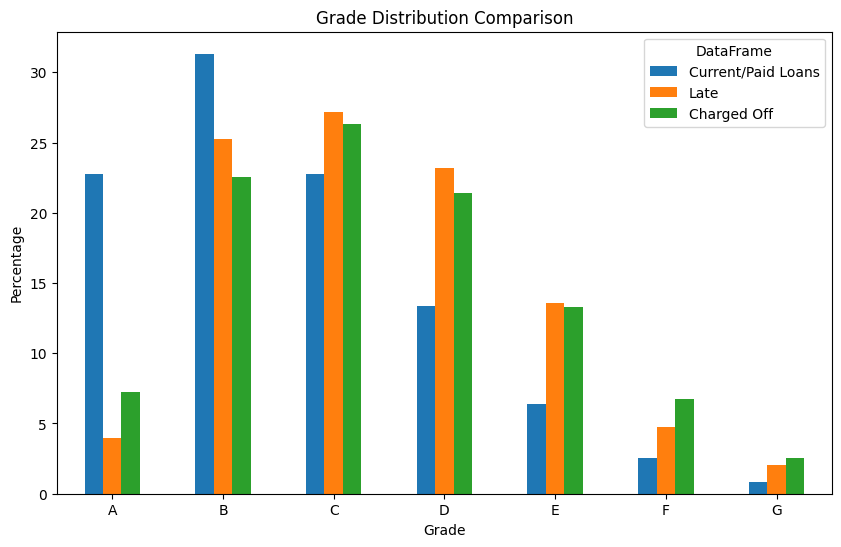

In [13]:
df1 = paid_loans_df
df2 = late_loan_df
df3 = charged_off_df

# Calculate the percentage of each grade in both dataframes
df1_percentage = df1['grade'].value_counts(normalize=True).sort_index() * 100
df2_percentage = df2['grade'].value_counts(normalize=True).sort_index() * 100
df3_percentage = df3['grade'].value_counts(normalize=True).sort_index() * 100

# Combine the percentages into a single dataframe
combined_df = pd.DataFrame({
    'Current/Paid Loans': df1_percentage,
    'Late': df2_percentage,
    'Charged Off': df3_percentage,
}).fillna(0)

# Plotting the histogram
combined_df.plot(kind='bar', figsize=(10, 6))
plt.title('Grade Distribution Comparison')
plt.xlabel('Grade')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='DataFrame')
plt.show()

From the graph above it can already be seen that the grade of the loan has a significant effect of how likely it is to become late or charged off. In particular an A grade loan is far more likely to be paid/current than late or charged off.

This needs to be looked at in more detail and visualised in a slightly different way so that the realtionship between the grade and status of a loan can be more clearly seen.

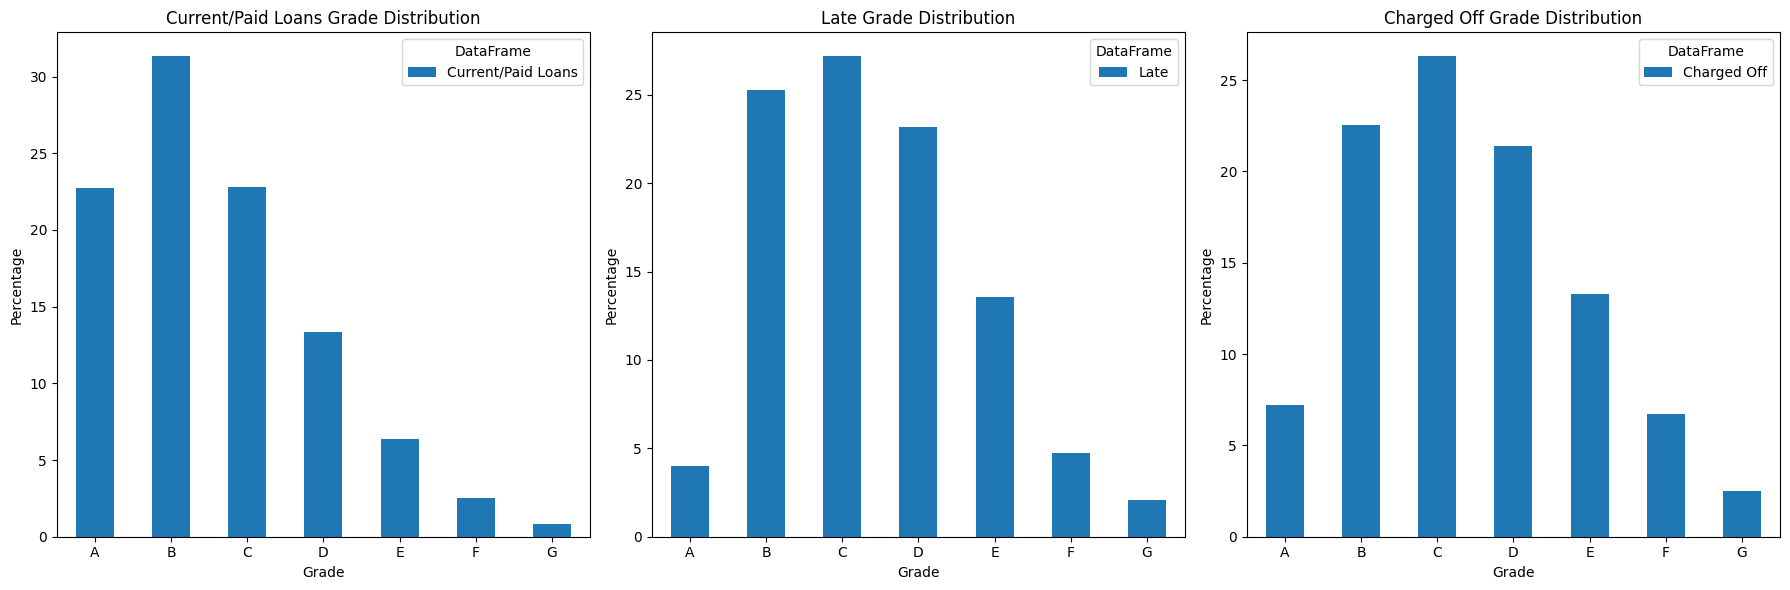

In [23]:
# Calculate the percentage of each grade in each dataframe
df1_percentage = df1['grade'].value_counts(normalize=True).sort_index() * 100
df2_percentage = df2['grade'].value_counts(normalize=True).sort_index() * 100
df3_percentage = df3['grade'].value_counts(normalize=True).sort_index() * 100

# Combine the percentages into a single dataframe
combined_df = pd.DataFrame({
    'Current/Paid Loans': df1_percentage,
    'Late': df2_percentage,
    'Charged Off': df3_percentage,
}).fillna(0)

# Plotting the histograms side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1 row, 3 columns for the subplots

# Plotting for each dataframe
for i, (column, data) in enumerate(combined_df.items()):
    ax = axes[i]  # Select the subplot
    data.plot(kind='bar', ax=ax)
    ax.set_title(f'{column} Grade Distribution')
    ax.set_xlabel('Grade')
    ax.set_ylabel('Percentage')
    ax.set_xticklabels(data.index, rotation=0)
    ax.legend().set_title('DataFrame')

plt.tight_layout()  # Ensures the plots are properly spaced
plt.show()

These charts show the relationship between loan grade and status more clearly. The current/paid loans are predominantly grades A to C, whereas for late and charged off loans they are predominantly grade B - D.  Late and charged off loans have a significantly higher number of D to G loans than current/paid loans. It is very clear that there is a strong relationship between loan grade and status.

It would be interesting to see a line graph for each of these data sets, as it would likely clarify this relationship further.

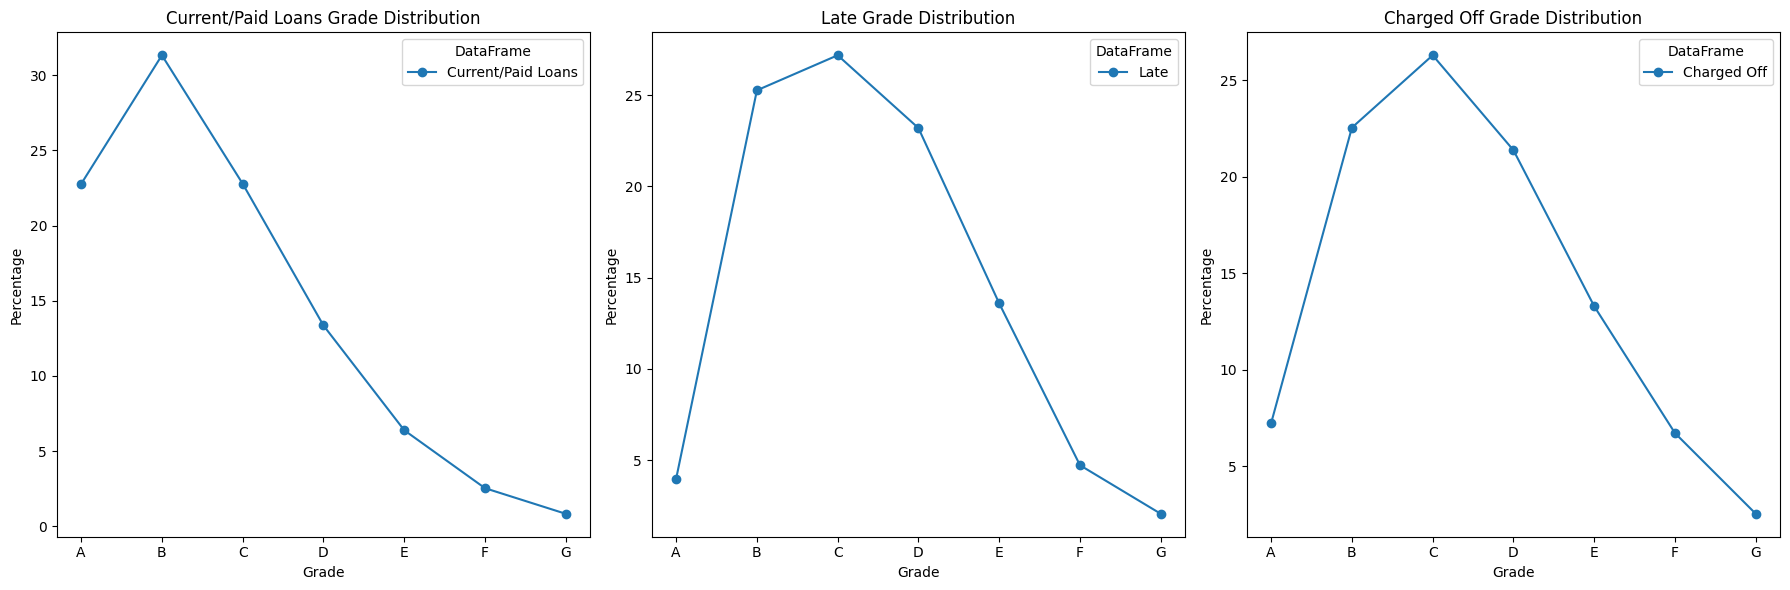

In [24]:
# Calculate the percentage of each grade in each dataframe
df1_percentage = df1['grade'].value_counts(normalize=True).sort_index() * 100
df2_percentage = df2['grade'].value_counts(normalize=True).sort_index() * 100
df3_percentage = df3['grade'].value_counts(normalize=True).sort_index() * 100

# Combine the percentages into a single dataframe
combined_df = pd.DataFrame({
    'Current/Paid Loans': df1_percentage,
    'Late': df2_percentage,
    'Charged Off': df3_percentage,
}).fillna(0)

# Plotting the line plots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1 row, 3 columns for the subplots

# Plotting for each dataframe
for i, (column, data) in enumerate(combined_df.items()):
    ax = axes[i]  # Select the subplot
    data.plot(kind='line', marker='o', ax=ax)
    ax.set_title(f'{column} Grade Distribution')
    ax.set_xlabel('Grade')
    ax.set_ylabel('Percentage')
    ax.set_xticks(range(len(data.index)))
    ax.set_xticklabels(data.index)
    ax.legend().set_title('DataFrame')

plt.tight_layout()  # Ensures the plots are properly spaced
plt.show()

Again, you can see how strong the relationship between loan grade and status is using these line graphs. The curve is highly skewed to the left for currrent/paid loans and moves significantly towards the centre for late loans, and slightly more centrally again for charged off loans. This comparison would be easier to visualise with all 3 graphs overlaid, so we shall do that next.

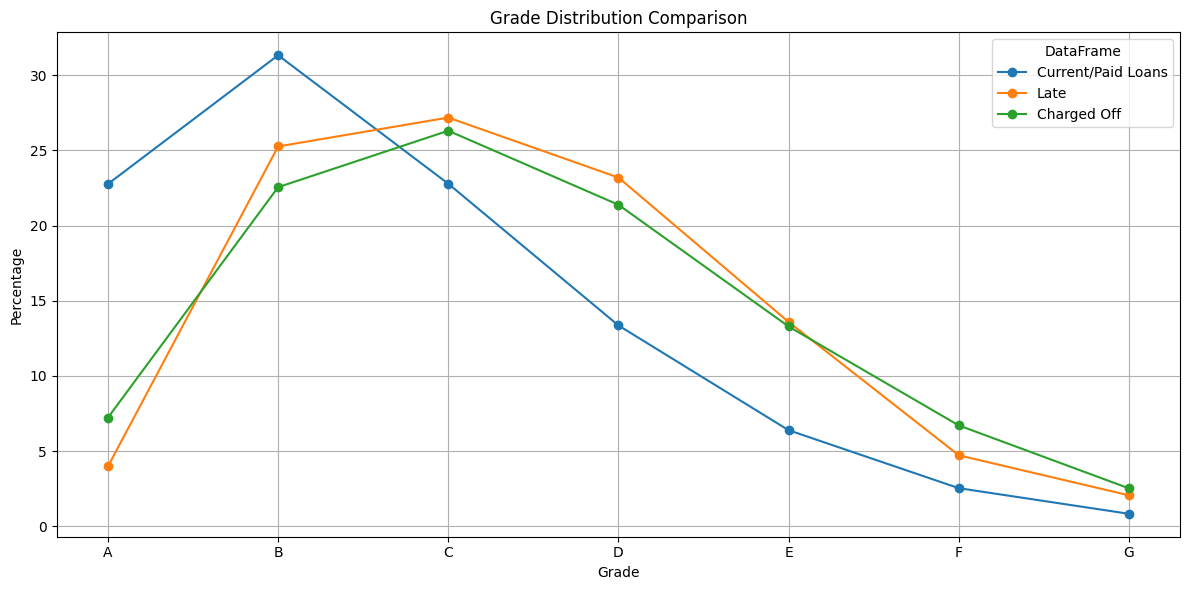

       Current/Paid Loans   Late  Charged Off
grade                                        
A                   22.76   3.99         7.23
B                   31.32  25.26        22.55
C                   22.78  27.18        26.30
D                   13.36  23.19        21.38
E                    6.40  13.59        13.29
F                    2.54   4.73         6.71
G                    0.84   2.07         2.53


In [25]:
# Calculate the percentage of each grade in each dataframe
df1_percentage = df1['grade'].value_counts(normalize=True).sort_index() * 100
df2_percentage = df2['grade'].value_counts(normalize=True).sort_index() * 100
df3_percentage = df3['grade'].value_counts(normalize=True).sort_index() * 100

# Combine the percentages into a single dataframe
combined_df = pd.DataFrame({
    'Current/Paid Loans': df1_percentage,
    'Late': df2_percentage,
    'Charged Off': df3_percentage,
}).fillna(0)

# Plotting the combined line plot
plt.figure(figsize=(12, 6))

# Plotting for each dataframe
for column, data in combined_df.items():
    plt.plot(data.index, data.values, marker='o', label=column)

# Setting labels and title
plt.title('Grade Distribution Comparison')
plt.xlabel('Grade')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='DataFrame')
plt.grid(True)

plt.tight_layout()
plt.show()

print(combined_df.round(2))

It is interesting to see how similar the profile is for late and charged off loans, suggesting that they are likely to lead to similar outcomes and that these late loans are very high risk for becoming charged off. 

Next we shall consider whether the purpose for the loan is likely to have an effect on the loan status. 

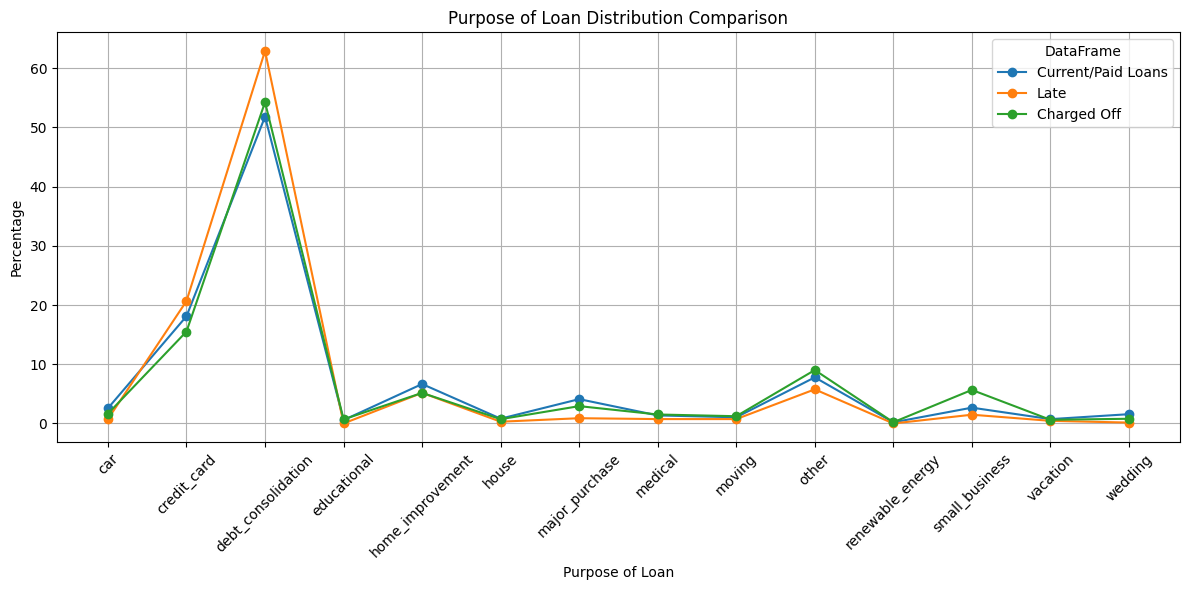

                    Current/Paid Loans   Late  Charged Off
purpose                                                   
car                               2.57   0.74         1.65
credit_card                      18.11  20.68        15.53
debt_consolidation               51.82  62.92        54.28
educational                       0.57   0.00         0.69
home_improvement                  6.66   5.17         5.16
house                             0.81   0.30         0.72
major_purchase                    4.11   0.89         2.93
medical                           1.36   0.74         1.51
moving                            1.04   0.74         1.22
other                             7.79   5.76         9.02
renewable_energy                  0.19   0.00         0.21
small_business                    2.67   1.48         5.66
vacation                          0.73   0.44         0.62
wedding                           1.57   0.15         0.79


In [26]:
# Calculate the percentage of each category in each dataframe
df1_percentage = df1['purpose'].value_counts(normalize=True).sort_index() * 100
df2_percentage = df2['purpose'].value_counts(normalize=True).sort_index() * 100
df3_percentage = df3['purpose'].value_counts(normalize=True).sort_index() * 100

# Combine the percentages into a single dataframe
combined_df = pd.DataFrame({
    'Current/Paid Loans': df1_percentage,
    'Late': df2_percentage,
    'Charged Off': df3_percentage,
}).fillna(0)

# Plotting the combined line plot
plt.figure(figsize=(12, 6))

# Plotting for each dataframe
for column, data in combined_df.items():
    plt.plot(data.index, data.values, marker='o', label=column)

# Setting labels and title
plt.title('Purpose of Loan Distribution Comparison')
plt.xlabel('Purpose of Loan')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='DataFrame')
plt.grid(True)

plt.tight_layout()
plt.show()

print(combined_df.round(2))

There are very few clear conclusions that can be drawn from this data. There is a slight increase in loans becoming charged off if the purpose is small business loan. There is a moderate increase in late payments for debt consolidation, however it does not appear to follow that these loans will become charged off.

Next we shall consider whether home ownership affects the status of a loan.

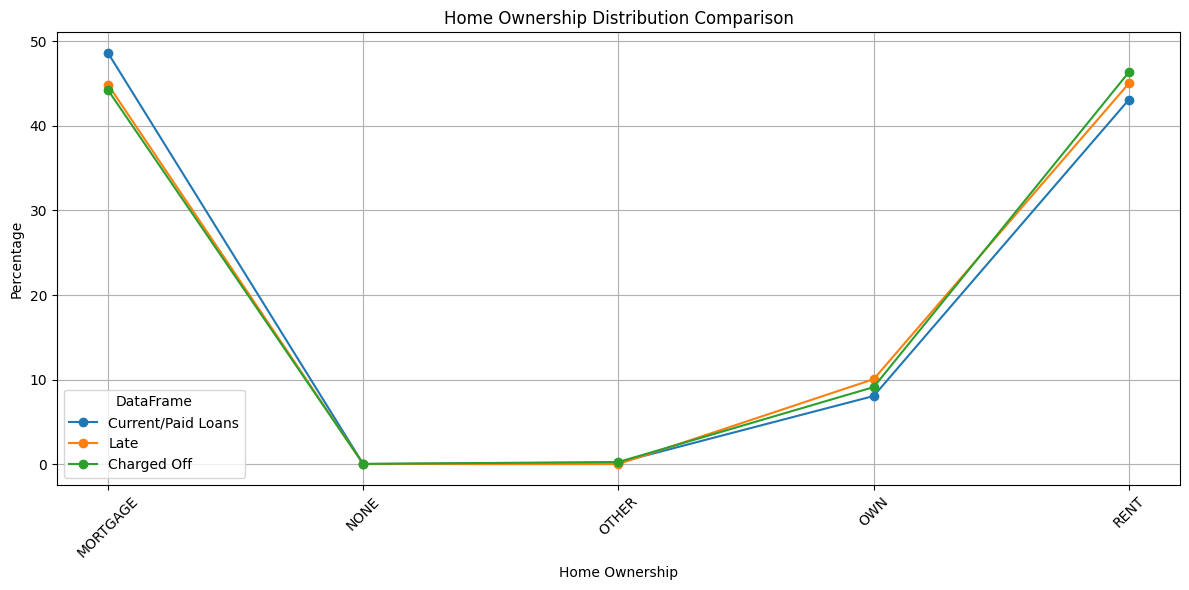

                Current/Paid Loans   Late  Charged Off
home_ownership                                        
MORTGAGE                     48.65  44.90        44.26
NONE                          0.00   0.00         0.02
OTHER                         0.18   0.00         0.24
OWN                           8.05  10.04         9.11
RENT                         43.12  45.05        46.38


In [27]:
# Calculate the percentage of each category  in each dataframe
df1_percentage = df1['home_ownership'].value_counts(normalize=True).sort_index() * 100
df2_percentage = df2['home_ownership'].value_counts(normalize=True).sort_index() * 100
df3_percentage = df3['home_ownership'].value_counts(normalize=True).sort_index() * 100

# Combine the percentages into a single dataframe
combined_df = pd.DataFrame({
    'Current/Paid Loans': df1_percentage,
    'Late': df2_percentage,
    'Charged Off': df3_percentage,
}).fillna(0)

# Plotting the combined line plot
plt.figure(figsize=(12, 6))

# Plotting for each dataframe
for column, data in combined_df.items():
    plt.plot(data.index, data.values, marker='o', label=column)

# Setting labels and title
plt.title('Home Ownership Distribution Comparison')
plt.xlabel('Home Ownership')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='DataFrame')
plt.grid(True)

plt.tight_layout()
plt.show()

print(combined_df.round(2))

This data and graph shows us that home owners with a mortgage are moderately less likely to default on payments and become charged off, whilst loans to renters are slightly more likely to default and become charged off. Interestingly people who own their home without a mortgage are slightly more likely to have a late or charged off loan status. 

Next we shall consider whether employment length affects the status of a loan.

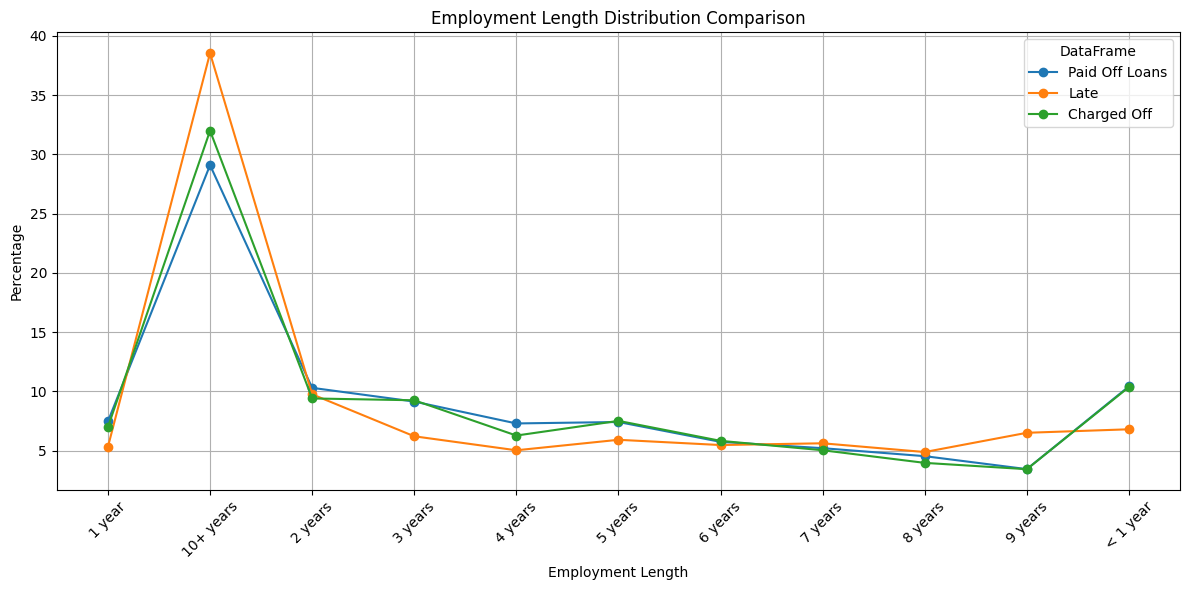

                   Paid Off Loans   Late  Charged Off
employment_length                                    
1 year                       7.47   5.32         6.99
10+ years                   29.10  38.55        32.00
2 years                     10.29   9.75         9.40
3 years                      9.14   6.20         9.24
4 years                      7.29   5.02         6.27
5 years                      7.41   5.91         7.51
6 years                      5.73   5.47         5.82
7 years                      5.20   5.61         5.03
8 years                      4.53   4.87         3.96
9 years                      3.43   6.50         3.43
< 1 year                    10.42   6.79        10.36


In [30]:
# Calculate the percentage of each category  in each dataframe
df1_percentage = df1['employment_length'].value_counts(normalize=True).sort_index() * 100
df2_percentage = df2['employment_length'].value_counts(normalize=True).sort_index() * 100
df3_percentage = df3['employment_length'].value_counts(normalize=True).sort_index() * 100

# Combine the percentages into a single dataframe
combined_df = pd.DataFrame({
    'Paid Off Loans': df1_percentage,
    'Late': df2_percentage,
    'Charged Off': df3_percentage,
}).fillna(0)

# Plotting the combined line plot
plt.figure(figsize=(12, 6))

# Plotting for each dataframe
for column, data in combined_df.items():
    plt.plot(data.index, data.values, marker='o', label=column)

# Setting labels and title
plt.title('Employment Length Distribution Comparison')
plt.xlabel('Employment Length')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='DataFrame')
plt.grid(True)

plt.tight_layout()
plt.show()

print(combined_df.round(2))

This data is quite variable and shows no overall trend between employment length and liklihood of a loan being late or charged off. There are several possible correlations with specific subsections of the data:

- Employment over 10 years appears to make loans moderately more likely to be late, and slightly more likely to be charged off.
- Employment of 9 years appears to make loans slightly more likely to be late.
- Employment of 3 to 5 years, and less than 1 year appears to make it slightly less likely that loans will be late. 

Next we shall consider whether annual income affects the status of a loan.

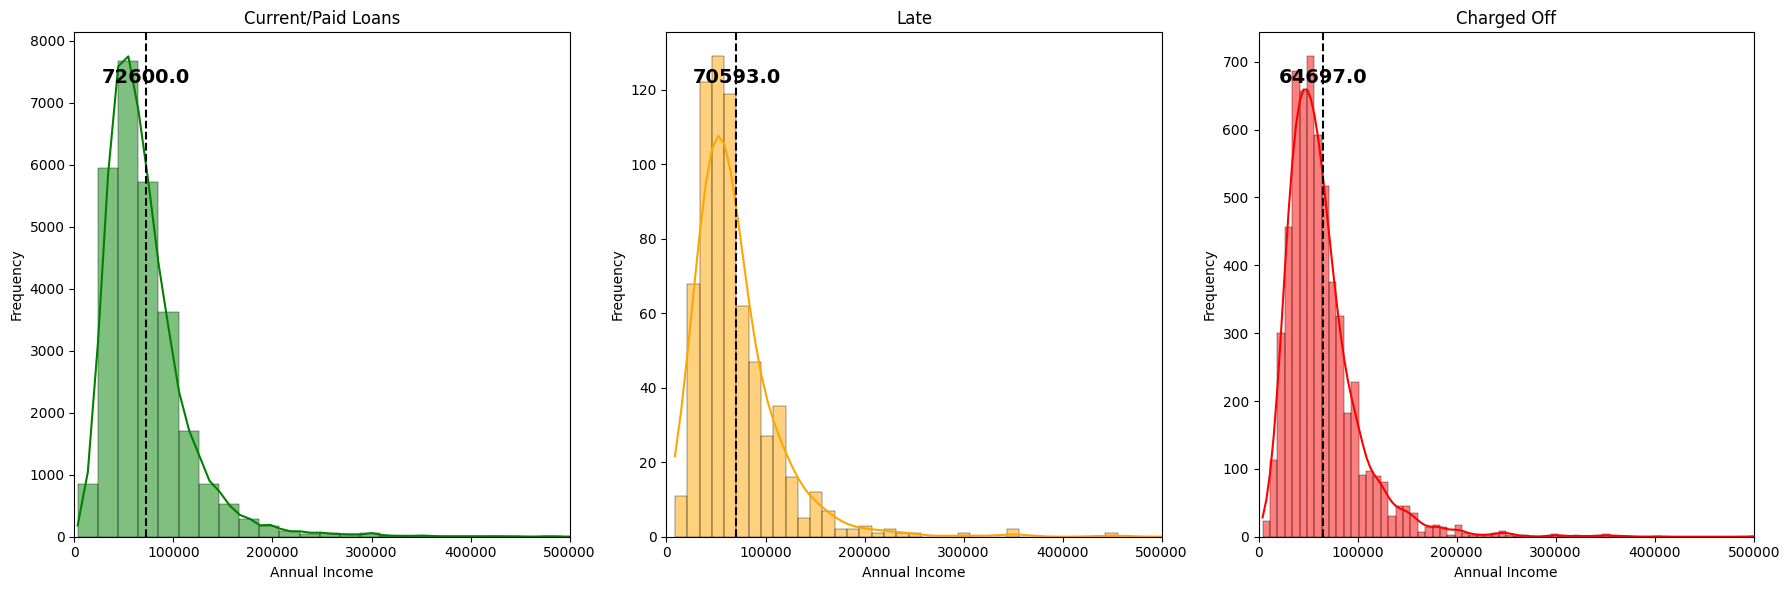

In [41]:
import seaborn as sns

plt.figure(figsize=(18, 6))

# Calculate medians
mean1 = df1['annual_inc'].mean().round()
mean2 = df2['annual_inc'].mean().round()
mean3 = df3['annual_inc'].mean().round()

# Histogram for df1
plt.subplot(1, 3, 1)
sns.histplot(df1['annual_inc'], bins=100, color='green', kde=True)
plt.title('Current/Paid Loans')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.xlim(0, 500000)
plt.axvline(mean1, color='black', linestyle='--', label=f'Median: {mean1}')
plt.text(mean1, plt.ylim()[1] * 0.9, f'{mean1}', color='black', ha='center',fontsize=14, weight='bold')

# Histogram for df2
plt.subplot(1, 3, 2)
sns.histplot(df2['annual_inc'], bins=100, color='orange', kde=True)
plt.title('Late')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.xlim(0, 500000)
plt.axvline(mean2, color='black', linestyle='--', label=f'Median: {mean2}')
plt.text(mean2, plt.ylim()[1] * 0.9, f'{mean2}', color='black', ha='center',fontsize=14, weight='bold')

# Histogram for df3
plt.subplot(1, 3, 3)
sns.histplot(df3['annual_inc'], bins=100, color='red', kde=True)
plt.title('Charged Off')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.xlim(0, 500000)
plt.axvline(mean3, color='black', linestyle='--', label=f'Median: {mean3}')
plt.text(mean3, plt.ylim()[1] * 0.9, f'{mean3}', color='black', ha='center',fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

From the graphs above we can see that annual income does appear to be linked to loan status, as shown in the table below.


| Loan Status                | Mean Income                 |
| -------------------------- | --------------------------- |
| Current/Paid               | £ 72,600                    |
| Late                       | £ 70,593                    |
| Charged Off                | £ 64,697                    |

The mean income is significanly higher for current/paid loans compared to charged off loans. The late loans more closely resemble the distribution of the current/paid loans than the charged off loans, suggesting that they are not as likely to become charged off as previously suggested by the loan grade data comparison.

Next we shall consider whether the loan amount affects the status of a loan.

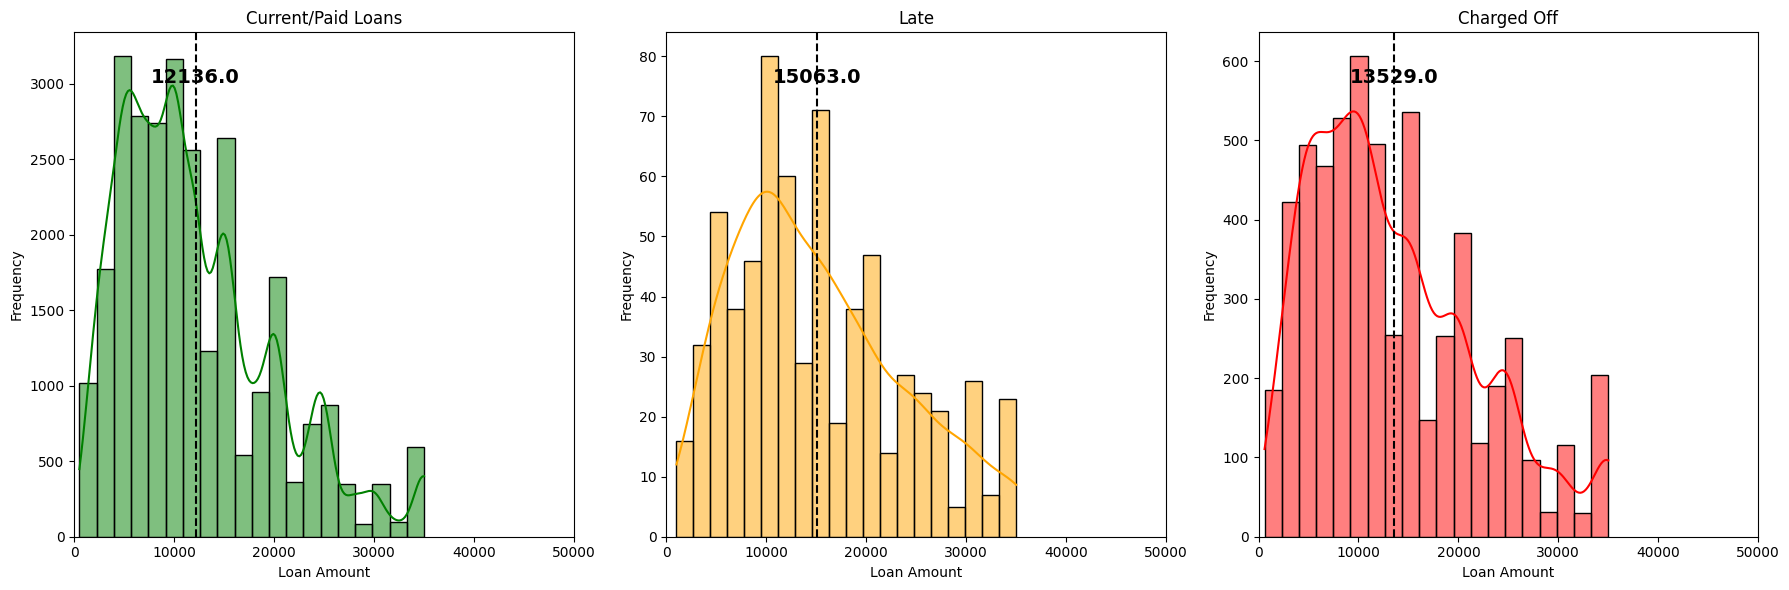

In [44]:
import seaborn as sns

plt.figure(figsize=(18, 6))

# Calculate medians
mean1 = df1['loan_amount'].mean().round()
mean2 = df2['loan_amount'].mean().round()
mean3 = df3['loan_amount'].mean().round()

# Histogram for df1
plt.subplot(1, 3, 1)
sns.histplot(df1['loan_amount'], bins=20, color='green', kde=True)
plt.title('Current/Paid Loans')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.xlim(0, 50000)
plt.axvline(mean1, color='black', linestyle='--', label=f'Mean: {mean1}')
plt.text(mean1, plt.ylim()[1] * 0.9, f'{mean1}', color='black', ha='center',fontsize=14, weight='bold')

# Histogram for df2
plt.subplot(1, 3, 2)
sns.histplot(df2['loan_amount'], bins=20, color='orange', kde=True)
plt.title('Late')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.xlim(0, 50000)
plt.axvline(mean2, color='black', linestyle='--', label=f'Mean: {mean2}')
plt.text(mean2, plt.ylim()[1] * 0.9, f'{mean2}', color='black', ha='center',fontsize=14, weight='bold')

# Histogram for df3
plt.subplot(1, 3, 3)
sns.histplot(df3['loan_amount'], bins=20, color='red', kde=True)
plt.title('Charged Off')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.xlim(0, 50000)
plt.axvline(mean3, color='black', linestyle='--', label=f'Mean: {mean3}')
plt.text(mean3, plt.ylim()[1] * 0.9, f'{mean3}', color='black', ha='center',fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

The loan amount does appear to have a moderate correlation with loan status, where current/paid loans are generally for a smaller amount than late or charged off loans. It is particularly interesting to note that larger loans are more likely to be late, but that it does not necessarily follow that those loans go on to charged off status.

| Loan Status                | Mean Loan Amount            |
| -------------------------- | --------------------------- |
| Current/Paid               | £ 12,136                    |
| Late                       | £ 15,063                    |
| Charged Off                | £ 13,529                    |

## DTI

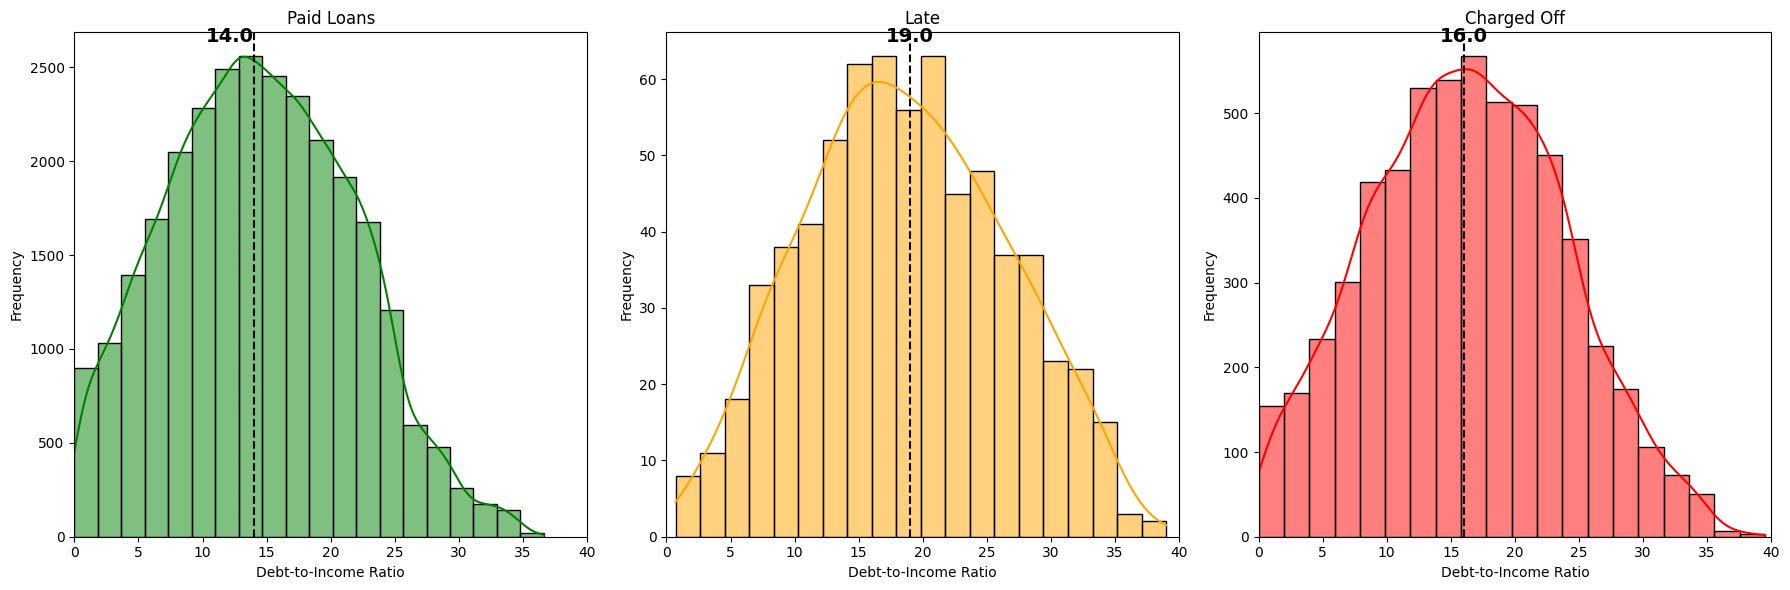

In [47]:
plt.figure(figsize=(18, 6))

# Calculate means
mean1 = df1['dti'].mean().round()
mean2 = df2['dti'].mean().round()
mean3 = df3['dti'].mean().round()

# Histogram for df1
plt.subplot(1, 3, 1)
sns.histplot(df1['dti'], bins=20, color='green', kde=True)
plt.title('Paid Loans')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Frequency')
plt.xlim(0, 40)
plt.axvline(mean1, color='black', linestyle='--', label=f'Mean: {mean1}')
plt.text(mean1, plt.ylim()[1] * 0.98, f'{mean1}', color='black', ha='right', fontsize=14, weight='bold')

# Histogram for df2
plt.subplot(1, 3, 2)
sns.histplot(df2['dti'], bins=20, color='orange', kde=True)
plt.title('Late')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Frequency')
plt.xlim(0, 40)
plt.axvline(mean2, color='black', linestyle='--', label=f'Mean: {mean2}')
plt.text(mean2, plt.ylim()[1] * 0.98, f'{mean2}', color='black', ha='center', fontsize=14, weight='bold')

# Histogram for df3
plt.subplot(1, 3, 3)
sns.histplot(df3['dti'], bins=20, color='red', kde=True)
plt.title('Charged Off')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Frequency')
plt.xlim(0, 40)
plt.axvline(mean3, color='black', linestyle='--', label=f'Median: {mean3}')
plt.text(mean3, plt.ylim()[1] * 0.98, f'{mean3}', color='black', ha='center', fontsize=14, weight='bold')


plt.tight_layout()
plt.show()

## Conclusion


There appear to be a multitude of factors that affect the likelihood of a loan status, as outlined in the table below:

| Loan Status| Significant Factor|Moderate Factor|Slight Factor|
| -----------| ------------------|---------------|-------------|
| Current/Paid|A Grade<br>Low dti ratio (<14)|Higher Income (eg £75K+)<br>Loan < £12K|Home Owner with Mortgage|
| Late|Low Grade (D-G)<br>Very High dti ratio (>19)|Debt Consolidation<br>Employment > 10 years<br>Loan > £15K|Debt Consolidation<br>Renter<br>Home Owner<br>Employment = 9 years|
| Charged Off|Low Grade (D-G)<br>High dti ratio (>16)|Lower Income (eg <£60K)|Small Business Loan<br>Renter<br>Employment > 10 years|

It is notable that although a number of factors increase the likelihood of a loan being late, these doesn't always increase the likelihood of being charged off.

The top 3 changes to reduce losses would be:

1. Approve more high (ideally A) grade loans, especially to high earners (over £75K) with a low dti ratio (<14).
2. Issue D-E grade loans with caution and avoid issuing F/G grade loans, especially in the presence of other risk factors, such as lower income (under £60K).
3. Be aware that high debt-to-income ratio is likely to affect repayments, especially for larger (>£12K) loans. With this in mind, avoid larger loan amounts with high debt-to-income ratios and/or low grade customers.

## Evaluation

Whilst it is important to be aware of what factors affect the likelihood of a loan becoming late or charged off, simply avoiding issuing loans to these customers will not necessarily increase profits.

Ultimately profit is made from these high risk, high reward loans as they are issued with significantly higher interest rates than similar loans with a lower risk profile. Furthermore, only a small percentage of these loans are currently charged off or late. The interest made on the many other high risk, high interest rate loans that are successfully paid off, will go some way to offsetting this loss.

Future analysis for this company could potentially focus on the profit to loss ratio produced by these high risk, high reward loans, and compare that to the low risk, low reward profile loans that have been recommended by this exploratory data analysis. Maximum profitability is unlikely to be achieved with a low risk portfolio of loans, and more work should be done to identify the ideal number of loans to aim for at each level of risk, to ensure a broad spread of risk with the maximum profit to loss ratio.